# Prédiction de valeurs manquantes : application à des mesures de capteur

Yewan Wang @ Miratlas
Juillet 2023

## Thème
Prétraitement des données de séries temporelles pour la complétion des turbulences atmosphériques liées aux conditions météorologiques.

## Contexte
La société "Miratlas" déploie un réseau instrumental mondiale pour surveiller les conditions météorologiques, en particulier les turbulences, afin de caractériser les conditions atmosphériques pour la communication optique en espace libre. Les variables de turbulence sont mesurées en observant les objets célestes brillants dans le ciel, tels que le soleil pendant la journée et Polaris pendant la nuit. Cependant, l'instrument ne peut pas effectuer de mesures efficaces si le soleil ou l'étoile est invisible, par exemple lorsqu'il y a des nuages ou lorsque les objets célestes sont en dessous de l'altitude d'observation. Par conséquent, nous avons de nombreuses valeurs manquantes pour les variables de turbulences. En revanche, la station météorologique obtient normalement des mesures continues sans interruption. Dans cet atelier, nous souhaitons analyser les relations internes et potentielles entre les variables de turbulence et les données météorologiques, afin de déterminer si nous pouvons obtenir des prédictions à court terme des turbulences en utilisant les variables météorologiques pour compléter les measures manquantes de la turbulence.

## Plan
1. Introduction : Présentation de la problématique et des enjeux.
2. Importation et visualization des données : Observation les évolutions et les valeurs manquantes des données.
3. Exploration des données : Analyse statistique des jeux de données, en terme de la corrélation, la saisonalité, les valeurs aberrantes pour explorer les relations potentielles entre les variables météorologiques et les turbulences.
4. Méthodes pre-selectionnées: <br>
    4.1. Modélisation prédictive : Construction d'un modèle prédictif en utilisant des techniques d'apprentissage automatique pour estimer les turbulences à court terme en fonction des données météorologiques.
5. Évaluation des performances : Évaluation du modèle prédictif et discussion des résultats obtenus.
6. Conclusion : Discusion les résultats obtenus ensemble.


## 1. Introduction 
### Turbulence atmosphérique
La turbulence atmosphérique fait référence à l’instabilité des mouvements de l’air. Comme un faisceau laser se propage dans l’atmosphère, son front d’onde subit des distorsions dues à des inhomogénéités dans l’indice de réfraction de l’air, qui sont causées par des variations de température et de pression. Ces effets sur un système optique peuvent être quantifiés par des paramètres de vision atmosphérique tels que la longueur de cohérence atmosphérique (paramètre Fried, r0) et l’angle isoplanatique.

Source:
- Apprends la science qui sous-tend les quatre principales causes de turbulence: https://parlonssciences.ca/ressources-pedagogiques/les-stim-expliquees/quest-ce-que-la-turbulence-atmospherique#:~:text=La%20turbulence%20en%20air%20clair%20se%20produit%20lorsque%20deux%20masses,de%20l'atmosph%C3%A8re%20appel%C3%A9e%20tropopause.

### Description du jeu de données 
1. time: sampling time  datetime64
2. d_ext_temp: external temperature, float64
3. d_humid: relative humidity, float64
4. d_rain_rate：rain rate, float64       
5. d_wind: wind speed, float64       
6. d_wind_dir: wind direction, 0° North, 180° south, float64       
7. __day_r0__: Fried parameter r0 day, float64       
8. day_see: Day Seeing, float64       
9. day_see_stddev, float64       
10. down_ir: downwelling irrandance, radiation infrared, float64       
11. humid: internal humidity, float64       
12. irrad: irradance, float64       
13. __isoplan__: Night Seeing isoplanetisme angle, Related to scintillation, float64       
14. __night_r0__: Fried parameter r0 night, float64       
15. night_see: Night Seeing, float64       
16. press: pression, float64       
17. pyr_temp: Pyrgeomete temperature, at 52° elevation, float64       
18. scint: Scintillation night, float64, 0-255       
19. sky_temp: sky temperature, float64       
20. status: four catogeries: Day time, Cloudy, Night time, Polaris locked $^*$ , string        
21. transp: Transparency night, float64, 0-255       
22. wat_col_hei: Total Water Column, water vapor, float64    

$^*$ : concerne l'étoile Polaris 

__en gras__ : les variables caractérisant la turbulence

## 2. Importation et visualisation des données


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *

In [2]:
cols_names = ['time', 'status', 'd_ext_temp', 'd_humid', 'd_rain_rate', 'd_wind', 'd_wind_dir', 'day_r0', 'day_see', 
            'day_see_stddev', 'down_ir', 'humid', 'irrad', 'isoplan', 'night_r0', 'night_see', 'press',
            'pyr_temp', 'scint', 'sky_temp', 'transp', 'wat_col_hei']
column_types = ['string', 'string', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float',
                'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float']
dtype = dict(zip(cols_names, column_types))

df = pd.read_csv('data/tenerife_2020.csv', dtype=dtype)
df['time'] = pd.to_datetime(df['time'], unit='ns')

df[df['time'].dt.month == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33129 entries, 0 to 33128
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time            33129 non-null  datetime64[ns]
 1   d_ext_temp      33129 non-null  float64       
 2   d_humid         29957 non-null  float64       
 3   d_rain_rate     238 non-null    float64       
 4   d_wind          31911 non-null  float64       
 5   d_wind_dir      33129 non-null  float64       
 6   day_r0          7007 non-null   float64       
 7   day_see         7007 non-null   float64       
 8   day_see_stddev  6915 non-null   float64       
 9   down_ir         33129 non-null  float64       
 10  humid           33129 non-null  float64       
 11  irrad           33129 non-null  float64       
 12  isoplan         0 non-null      float64       
 13  night_r0        0 non-null      float64       
 14  night_see       0 non-null      float64       
 15  pr

In [3]:
missing_df = missingDF(df)
print('Dataframe des variables associées leurs taux de valeurs manquantes')
missing_df

Dataframe des variables associées leurs taux de valeurs manquantes


,0
time,0.00
d_ext_temp,0.00
d_humid,3.88
d_rain_rate,99.03
d_wind,12.97
d_wind_dir,0.00
day_r0,73.92
day_see,73.92
day_see_stddev,74.20
down_ir,0.00



- Les variables continues sans trous (ou presque) sont : __d_ext_temp__ , __d_wind_dir__, __down_ir__, __pyr_temp__, __press__, __sky_temp__, __wat_col_hei__, __humid__, __irrad__

- Le taux de manquants pour les variables à trous qu'on cherche à prédire sont d'env 74%

- Les variables (quasi ou entièrement) vides sont __isoplan__ et __d_rain_rate__

On va supprimer ces deux dernières variables car elles ne nous serviront pas.


In [4]:
df = df.drop(['isoplan','d_rain_rate'],axis=1)

On crée des dataframes par saison (cela pourra être utile pour l'observation des données, pour la création de modèle etc)

In [5]:
#Décomposition par saison 

hiver = pd.concat([df[(df['time'].dt.month >= 12) & (df['time'].dt.day >=1)], df[(df['time'].dt.month <= 2) & (df['time'].dt.day <= 28)]])
printemps = df[(df['time'].dt.month >= 3) & (df['time'].dt.day >=1) & (df['time'].dt.month <= 5) & (df['time'].dt.day <= 31)]
ete = df[(df['time'].dt.month >= 6) & (df['time'].dt.day >=1) & (df['time'].dt.month <= 8) & (df['time'].dt.day <= 31)]
automne = df[(df['time'].dt.month >= 9) & (df['time'].dt.day >=1) & (df['time'].dt.month <= 11) & (df['time'].dt.day <= 31)]
            

In [6]:
#hiver,automne,printemps,été
missingDF(printemps)

,0
time,0.00
d_ext_temp,0.00
d_humid,7.01
d_wind,4.76
d_wind_dir,0.00
day_r0,68.02
day_see,68.02
day_see_stddev,68.41
down_ir,0.00
humid,0.02


__Hiver__ : bcp de valeurs manquantes autant chez les variables à prédire que chez les variables pouvant servir à prédire (__scint__, __transp__, __d_wind__ etc) = bof

__Automne__ : pas mal de valeurs manquantes (__day_r0__, __night_r0__) mais peu de val manquantes chez les variables servant à prédire

__Printemps__ :  peu de valeurs manquantes (__day_r0__, __night_r0__) et peu de val manquantes chez les variables servant à prédire 

__Ete__ : peu de val manquante chez __day_r0__ mais bcp chez __night_r0__ et chez les variables pour prédire


# 2. Importation et visualization des données

### Draw demos for one or multiple parameters

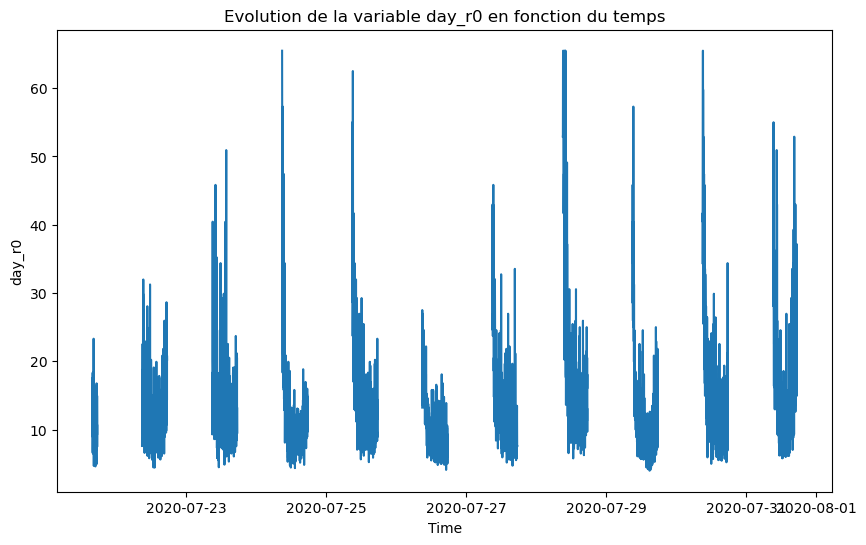

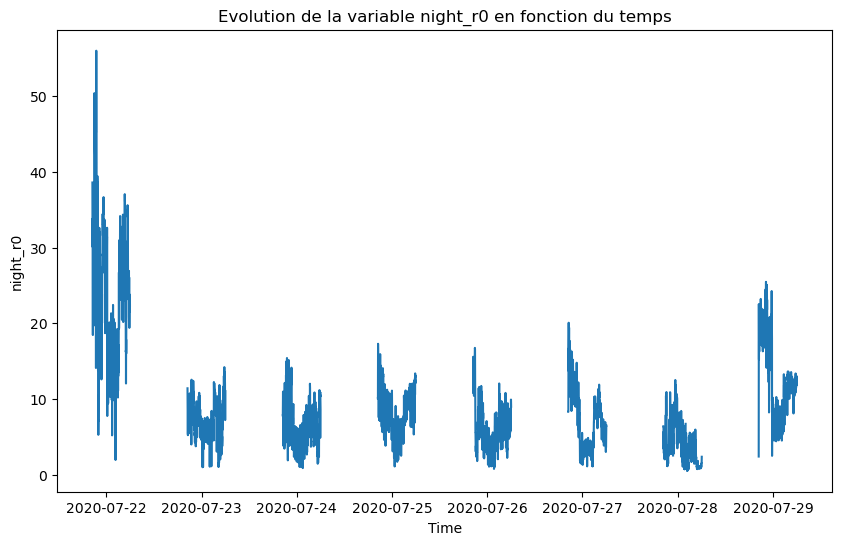

In [10]:
# Dessinez les courbes des variables de juillet.
df_month = df[(df['time'].dt.month == 7)]
plot_one_param(df_month, 'day_r0')
plot_one_param(df_month, 'night_r0')


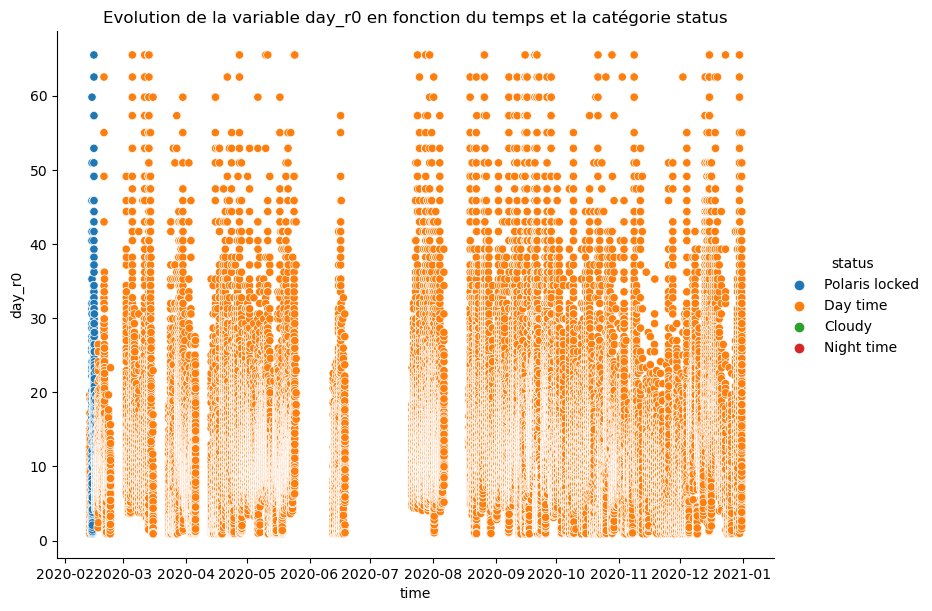

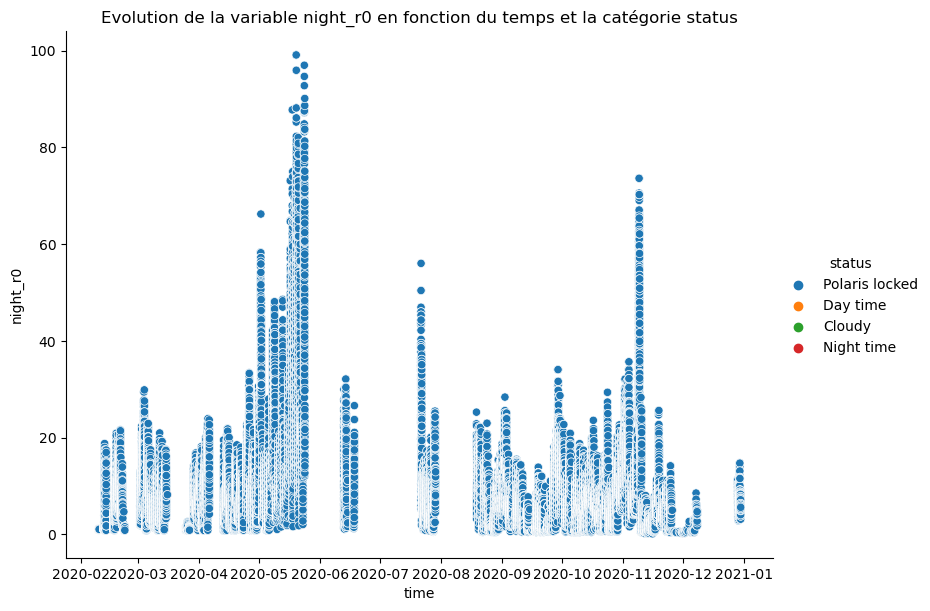

In [7]:
plot_one_params_based_categories(df, 'day_r0', 'status')
plot_one_params_based_categories(df, 'night_r0', 'status')

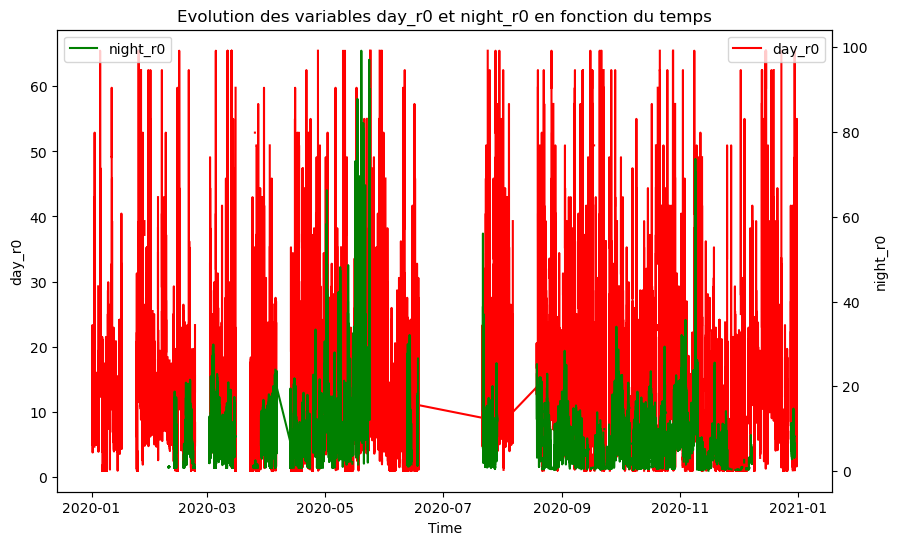

In [9]:
plot_two_params(df, 'day_r0', 'night_r0')

## 2. Statistiques descriptives

#### Variables quantitatives

In [11]:
df.describe()

,d_ext_temp,d_humid,d_wind,d_wind_dir,day_r0,day_see,day_see_stddev,down_ir,humid,irrad,night_r0,night_see,press,pyr_temp,scint,sky_temp,transp,wat_col_hei
count,422114.000000,405752.000000,367379.000000,422114.000000,110080.000000,110080.000000,1.088910e+05,422114.000000,422024.000000,422102.000000,101836.000000,101836.000000,422114.000000,422114.00000,113377.000000,422114.000000,140213.000000,422114.000000
mean,10.055595,37.645223,26.114661,213.924617,11.974746,2.225290,5.215026e+05,276.433488,35.779387,14.155572,9.960454,3.038050,768.893371,-9.79341,43.226449,6.589102,82.067824,4.241670
std,5.602427,25.380561,15.288152,112.589982,8.496639,2.758623,3.450690e+07,50.731154,7.685404,5.655733,9.525078,3.693798,3.808271,12.59542,19.697992,11.029255,56.263202,1.648532
min,-3.467000,0.100000,1.609000,9.000000,0.917000,0.210000,1.000000e-02,149.494000,16.750000,7.798090,0.122000,0.139000,746.980000,-46.55000,0.020000,-22.110000,2.009000,0.876000
25%,5.839000,17.600000,14.484000,133.730000,6.773000,0.910000,3.600000e-01,235.409000,31.300000,8.643990,4.113000,1.056000,766.380000,-19.31000,28.633000,0.530000,27.168000,3.201000
50%,9.822000,32.500000,24.140000,245.050000,10.338000,1.330000,5.500000e-01,282.415000,36.050000,10.536800,7.386000,1.795000,769.410000,-7.49000,47.119000,7.230000,82.418000,4.141000
75%,14.350000,51.700000,33.796000,313.450000,15.110000,2.030000,8.300000e-01,316.794000,40.570000,20.573900,12.681000,3.249000,771.730000,0.25000,58.706000,14.710000,130.331000,5.368000
max,27.022000,96.100000,146.450000,351.000000,65.476000,15.000000,4.038450e+09,435.732000,57.330000,20.961200,99.111000,92.934000,777.360000,22.93000,123.619000,39.170000,251.585000,11.125000


__Affichage des box-plot__ : 

<Axes: >

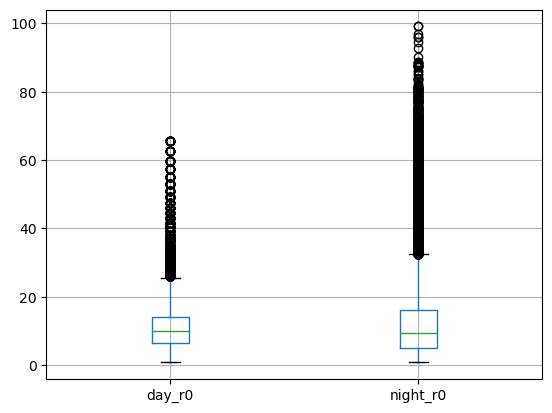

In [13]:
df[['day_r0','night_r0']].boxplot()

__Affichage des histogrammes__ :

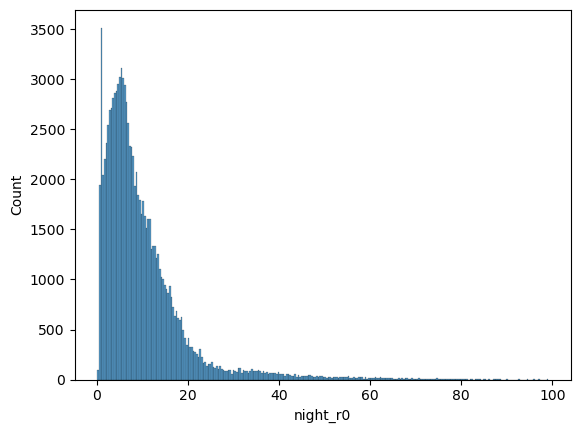

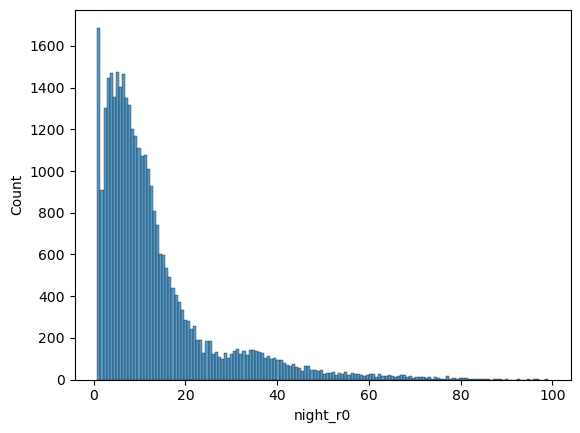

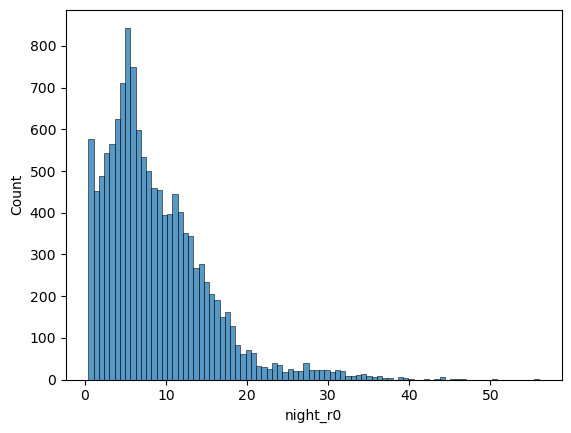

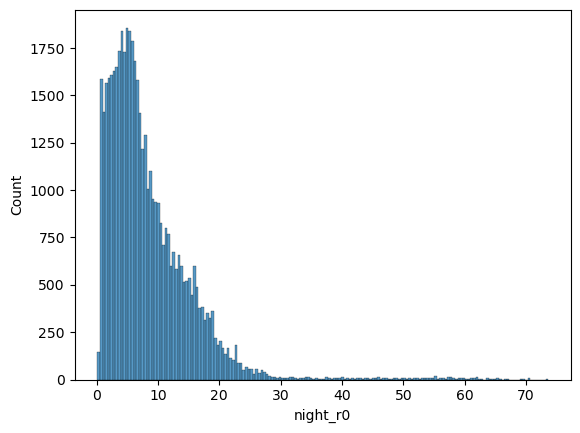

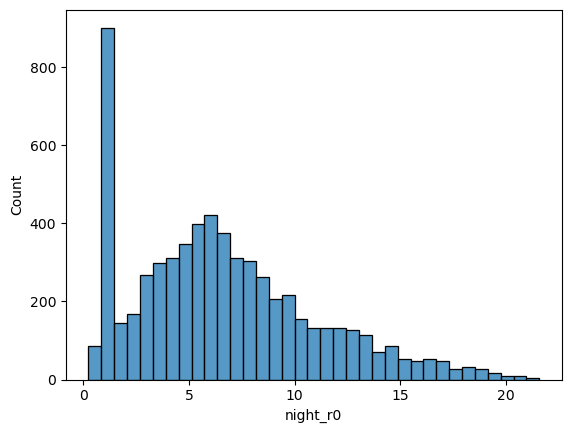

In [16]:
sns.histplot(df.night_r0) #day_r0
plt.show()
sns.histplot(printemps.night_r0) #day_r0
plt.show()
sns.histplot(ete.night_r0) #day_r0
plt.show()
sns.histplot(automne.night_r0) #day_r0
plt.show()
sns.histplot(hiver.night_r0) #day_r0
plt.show()

#### Variables qualitatives

L'hiver


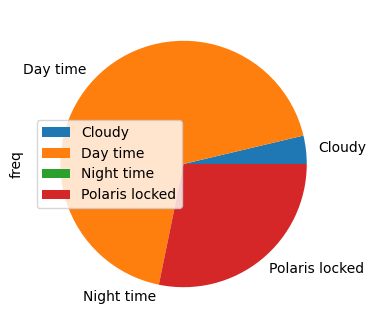

L'automne


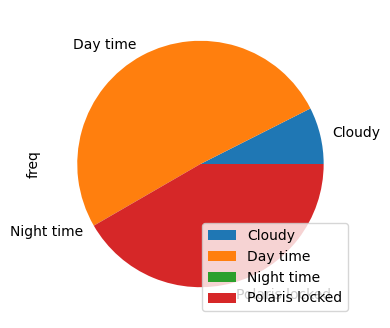

Le printemps


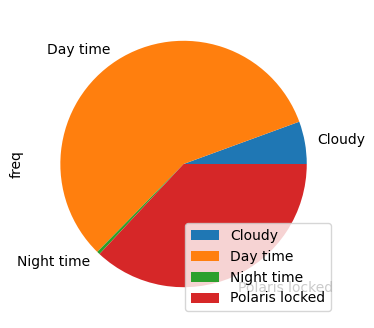

L'été


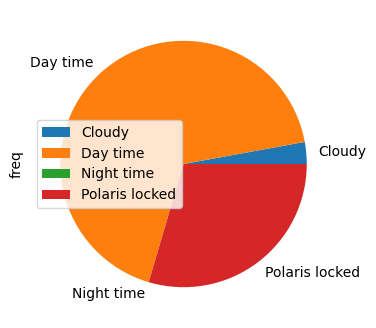

In [17]:
print("L'hiver")
t = pd.crosstab(hiver.status, "freq", normalize = True)
t.plot.pie(subplots=True, figsize = (4, 4))
plt.show()

print("L'automne")
t = pd.crosstab(automne.status, "freq", normalize = True)
t.plot.pie(subplots=True, figsize = (4, 4))
plt.show()

print("Le printemps")
t = pd.crosstab(printemps.status, "freq", normalize = True)
t.plot.pie(subplots=True, figsize = (4, 4))
plt.show()

print("L'été")
t = pd.crosstab(ete.status, "freq", normalize = True)
t.plot.pie(subplots=True, figsize = (4, 4))
plt.show()

In [18]:
#df,hiver,automne,printemps,ete

hiver.status.unique()
print("L'hiver \n", pd.crosstab(hiver.status, "freq"),"\n")

automne.status.unique()
print("L'automne \n", pd.crosstab(automne.status, "freq"),"\n")

printemps.status.unique()
print("Le printemps \n", pd.crosstab(printemps.status, "freq"),"\n")

ete.status.unique()
print("L'été \n", pd.crosstab(ete.status, "freq"))

L'hiver 
 col_0            freq
status               
Cloudy           2100
Day time        38565
Night time          1
Polaris locked  15983 

L'automne 
 col_0            freq
status               
Cloudy          10974
Day time        75027
Night time         12
Polaris locked  61407 

Le printemps 
 col_0            freq
status               
Cloudy           5292
Day time        54113
Night time        381
Polaris locked  35038 

L'été 
 col_0            freq
status               
Cloudy           1431
Day time        33718
Night time          2
Polaris locked  14752


#### Description conjointe de caractères quantitatifs

hiver


/Users/macbook/Documents/Mines_Nancy/Césure/datacraft/Atelier Miratlas/2310-Yewan-Miratlas/utils.py:103: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


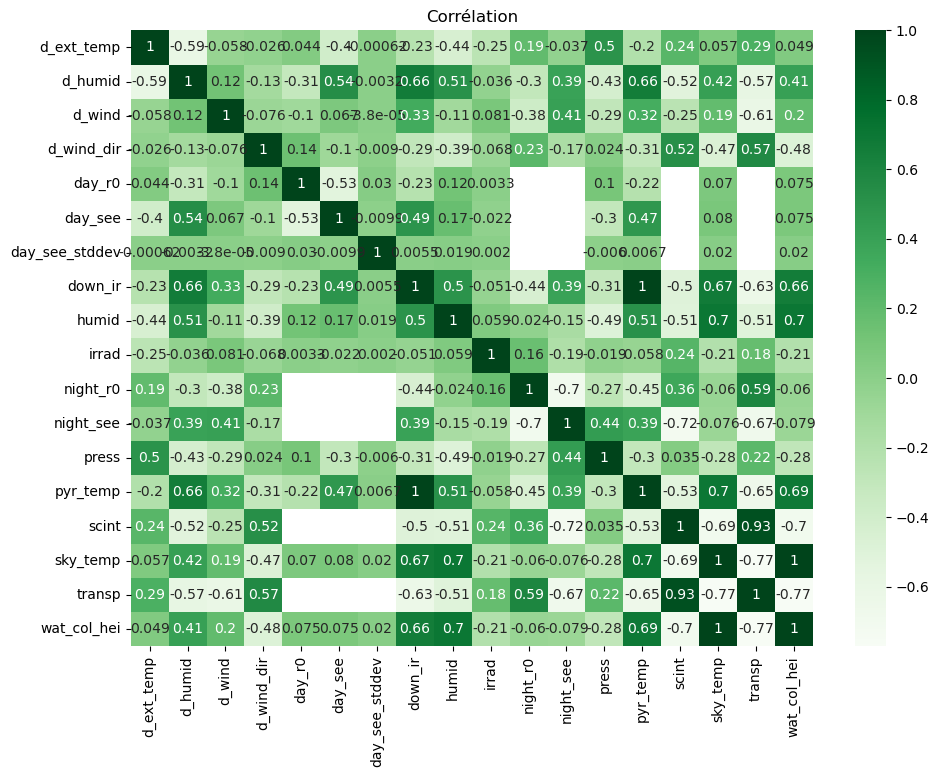

automne


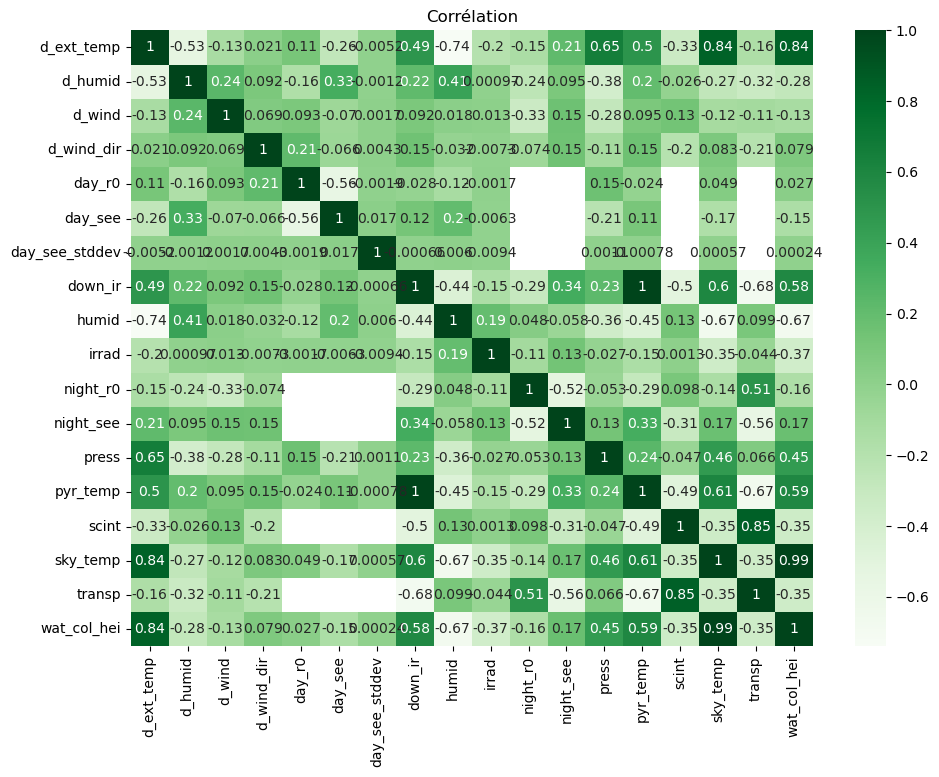

printemps


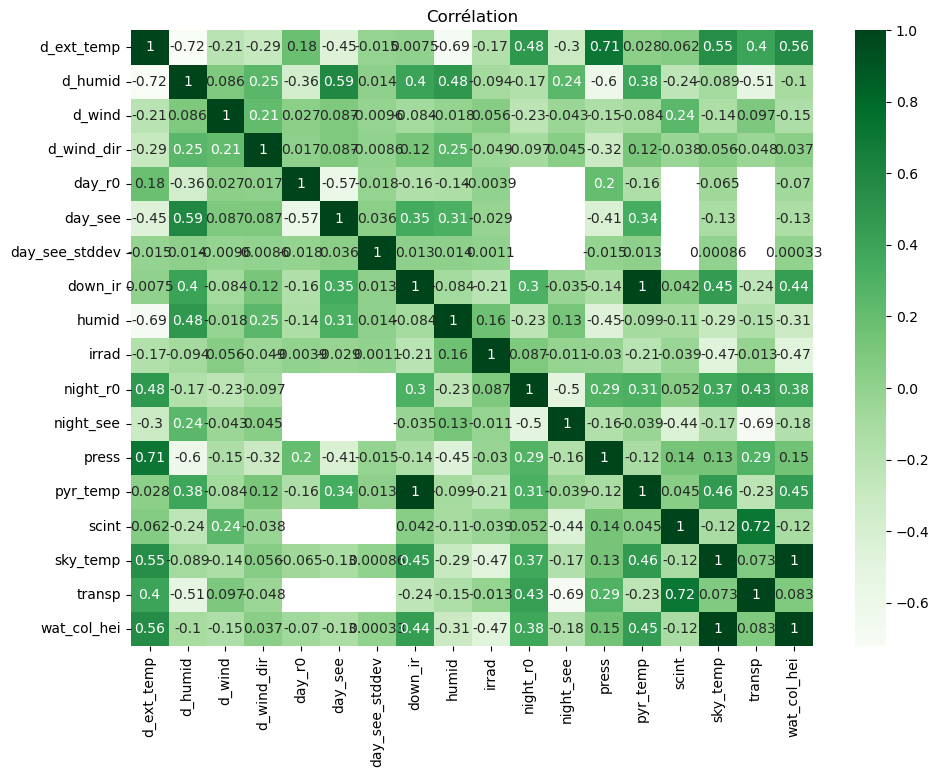

ete


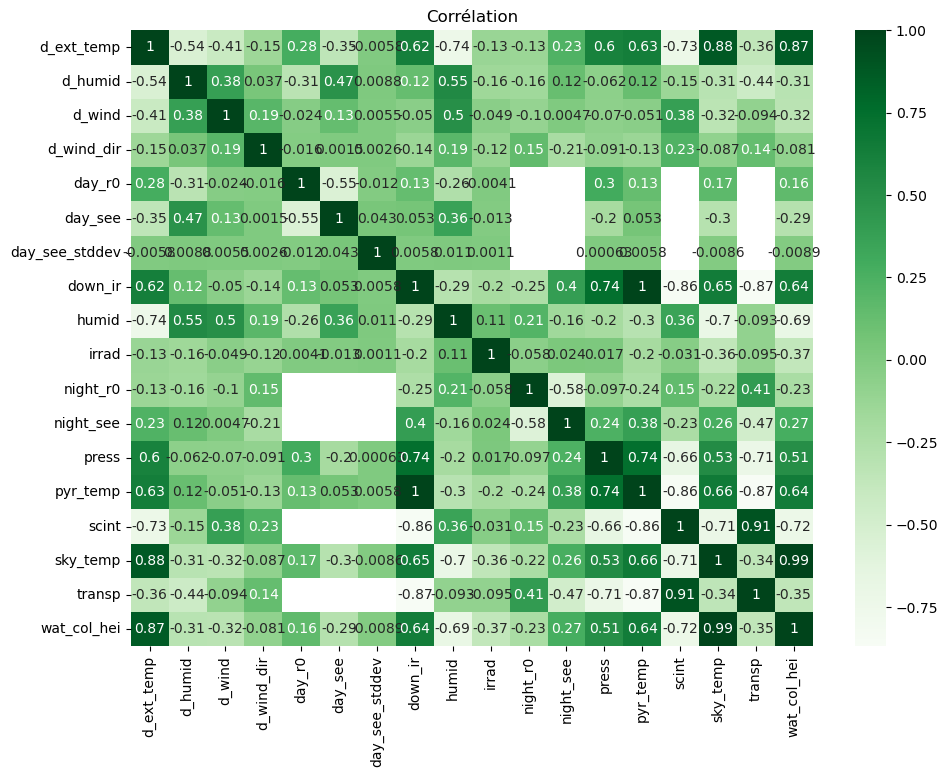

sur l'année


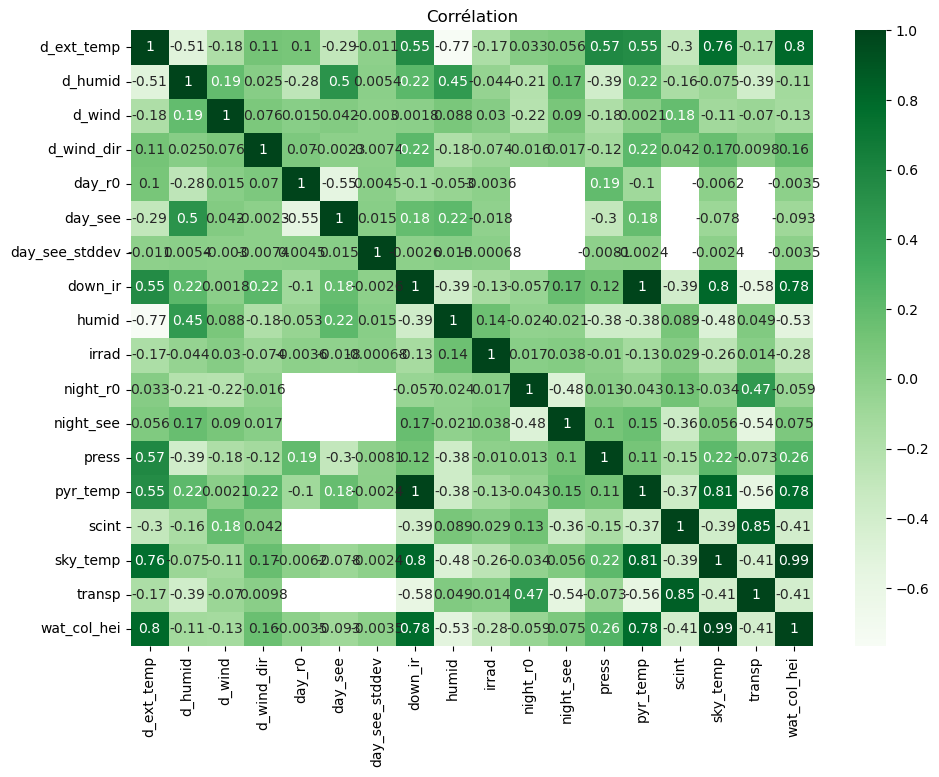

In [20]:
print("hiver")
plot_corr(hiver)
print("automne")
plot_corr(automne)
print("printemps")
plot_corr(printemps)
print("ete")
plot_corr(ete)
print("sur l'année")
plot_corr(df)

## Résumé des corrélations ( $\geq 0.84 \% $ ) : 

Variables corrélées pour toute saison : `sky_temp ~ wat_col_hei` et `pyt_temp ~ down_ir`

### Hiver : 

`transp ~ scint`

### Automne : 

`transp ~ scint`, `d_ext_temp ~ sky_temp`,`d_ext_temp ~ wat_col_hei`

### Printemps : 

### Eté : 

`transp ~ scint`, `d_ext_temp ~ sky_temp`,`d_ext_temp ~ wat_col_hei`, 


Le coefficient de correlation entre wat_col_hei et sky_temp pour la saison printemps est de 99.544 % 



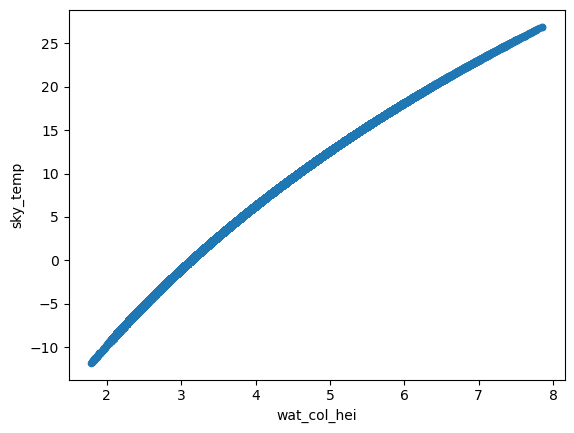

Le coefficient de correlation entre down_ir et pyr_temp pour la saison printemps est de 99.853 % 



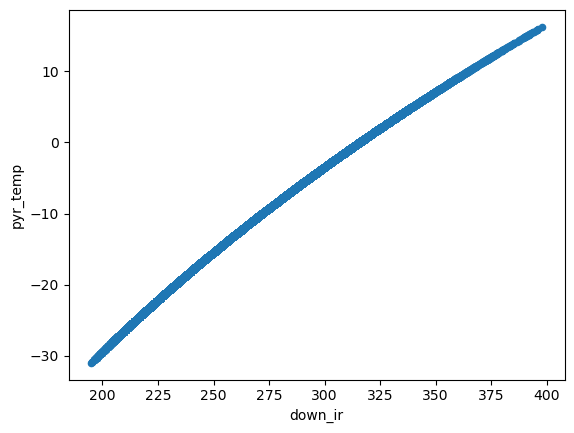

In [22]:
Hiver,Automne,Printemps,Ete = [[hiver,'hiver'],[automne,'automne'],[printemps,'printemps'],[ete,'été']]

plot_corr_saison_variable('wat_col_hei', 'sky_temp', Printemps)
plot_corr_saison_variable('down_ir', 'pyr_temp', Printemps)

### Description conjointe d’un caractère quantitatif et d’un caractère qualitatif

In [56]:
df.groupby("status").mean()

/var/folders/w7/6rt7vbvd7bqbx0q2zdmnfvm40000gn/T/ipykernel_4531/1618936183.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("status").mean()


,d_ext_temp,d_humid,d_wind,d_wind_dir,day_r0,day_see,day_see_stddev,down_ir,humid,irrad,night_r0,night_see,press,pyr_temp,scint,sky_temp,transp,wat_col_hei
status,,,,,,,,,,,,,,,,,,
Cloudy,6.673387,67.894883,33.023590,239.746422,NaN,NaN,NaN,323.125838,39.341150,20.169846,NaN,NaN,766.622150,1.363192,NaN,6.376370,17.282324,4.077362
Day time,10.989618,40.705176,25.582096,210.103105,11.973561,2.259299,588378.699021,290.458510,35.627237,10.001468,NaN,NaN,768.788042,-6.235394,NaN,11.299970,NaN,4.937833
Night time,0.498775,93.165909,34.804093,309.969596,NaN,NaN,NaN,316.236692,42.874924,19.921494,6.38700,8.096182,760.796869,0.080152,25.979769,1.533434,62.580923,3.338593
Polaris locked,10.202215,31.897753,25.649758,219.244538,14.864112,1.870377,413.909196,273.293186,36.356199,19.831404,9.96084,3.037503,769.130685,-10.265131,43.228427,5.958783,91.853203,4.074133


In [57]:
#ex ou on se concentre sur une variable avec sky_temp

df.groupby("status")["sky_temp"].agg([np.mean, np.std, np.median, np.min, np.max])

,mean,std,median,amin,amax
status,,,,,
Cloudy,6.376370,6.242427,4.13,-13.15,20.19
Day time,11.299970,9.165211,10.93,-17.73,39.17
Night time,1.533434,1.904822,1.25,-7.37,20.77
Polaris locked,5.958783,8.805860,6.45,-18.59,22.45


<Axes: xlabel='sky_temp', ylabel='Count'>

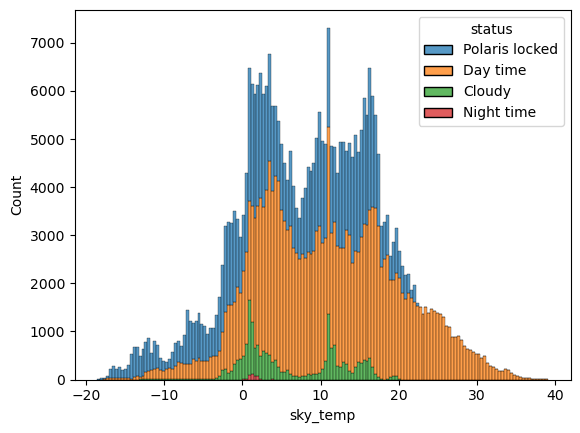

In [23]:
sns.histplot(data = df, x="sky_temp", hue = "status", multiple = "stack")

#### Description conjointe de deux caractères quantitatifs et d’un caractère qualitatif

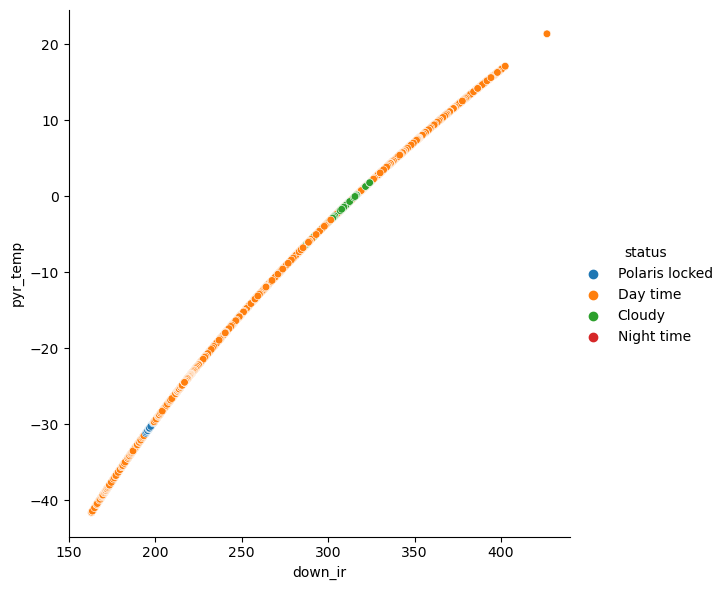

In [60]:
sns.relplot(x = "down_ir", y = "pyr_temp", hue = "status", data = df, height = 6, s = 30)

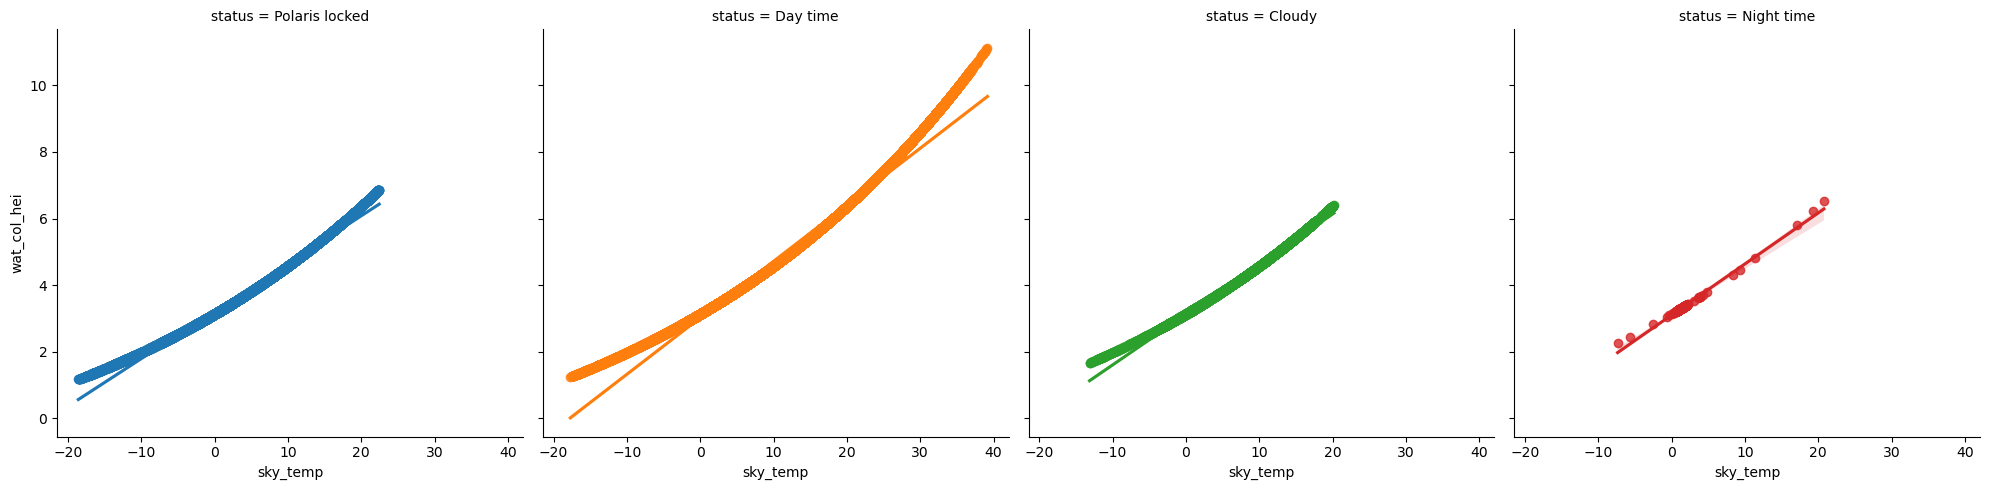

In [62]:
sns.lmplot(data = df, x="sky_temp", y = "wat_col_hei", hue = "status", col = "status")

## 3. Tendance et saisonnalité

### Affichage de la tendance

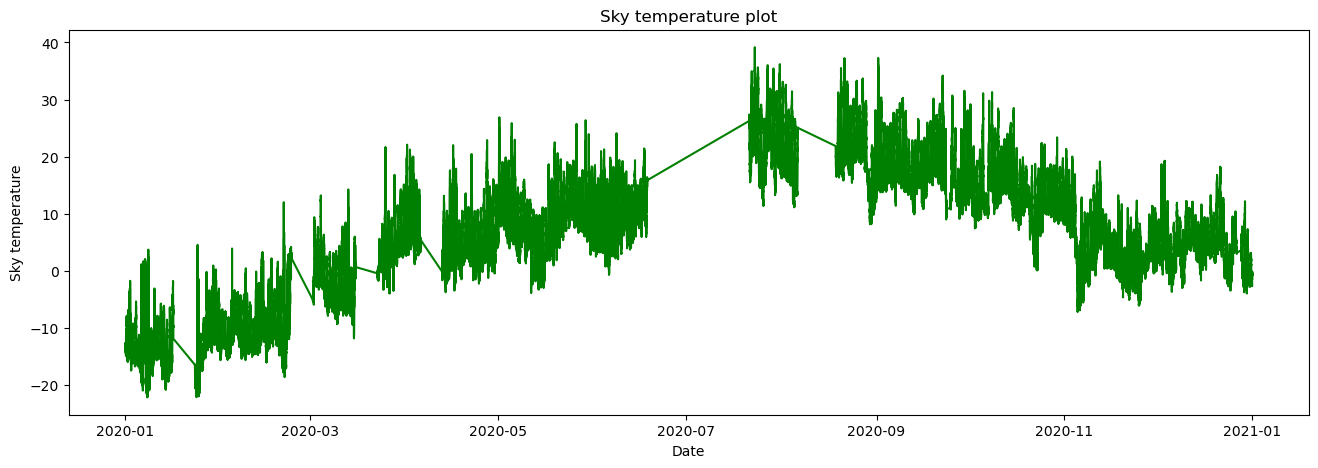

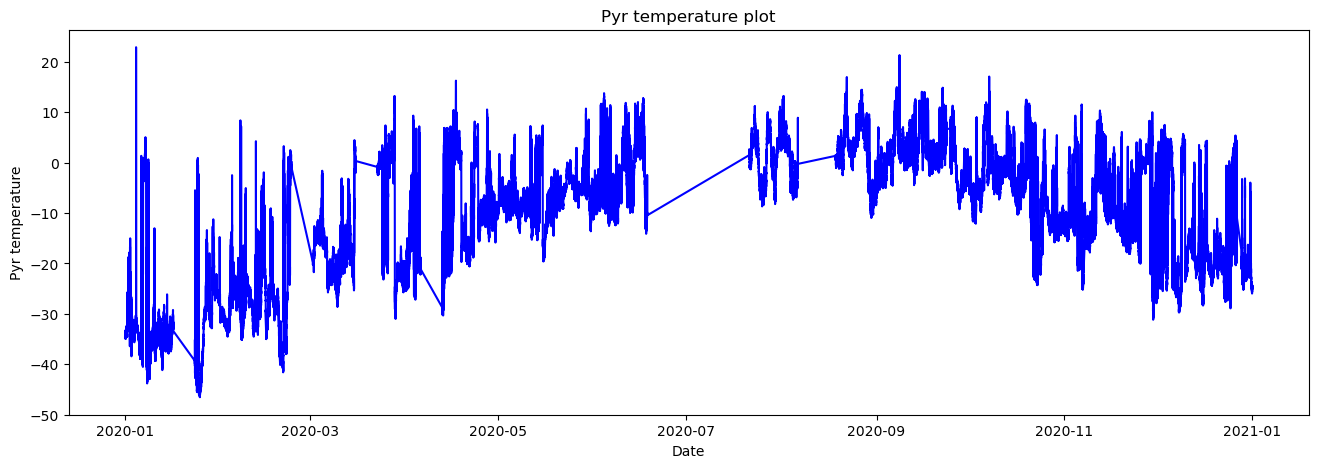

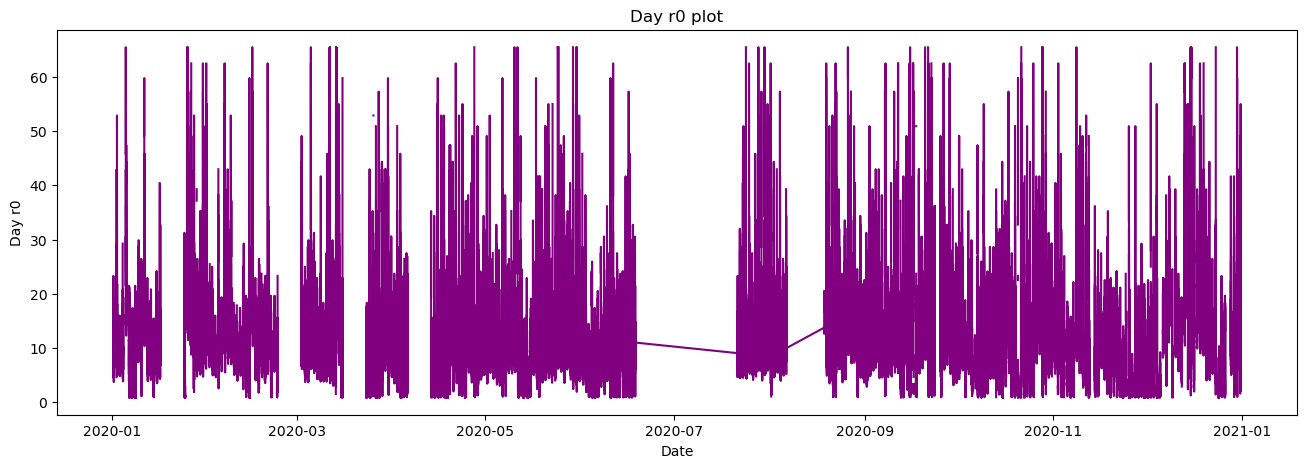

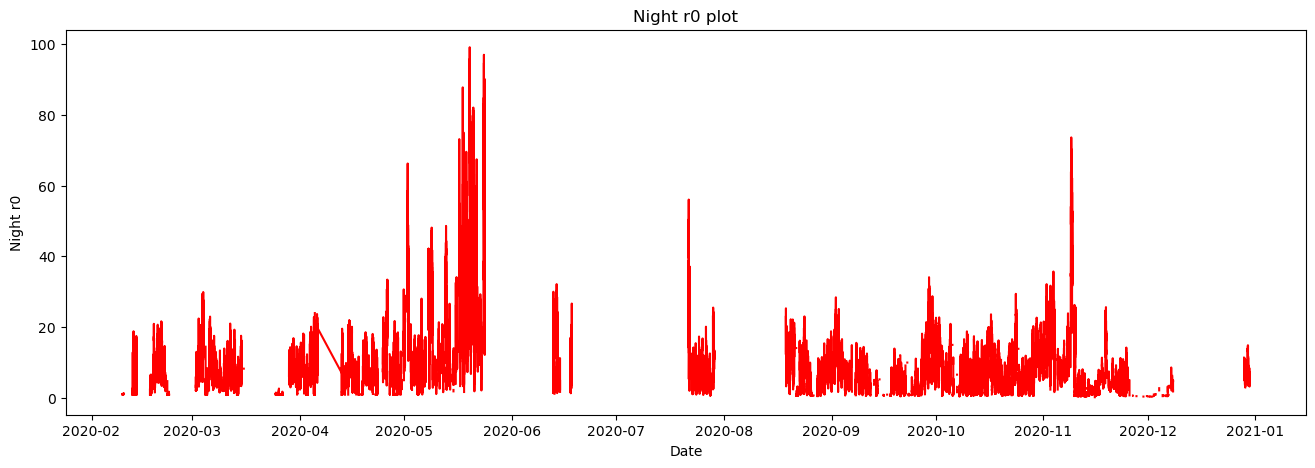

In [64]:
df['day'] = df['time'].dt.day
df['month'] = df['time'].dt.month
month = df['month'].unique()

plot_df(df, x=df.time, y=df.sky_temp, ylabel = "Sky temperature" ,title='Sky temperature plot',color = 'green')  

plot_df(df, x=df.time, y=df.pyr_temp, ylabel = "Pyr temperature" ,title='Pyr temperature plot', color = 'blue')  

plot_df(df, x=df.time, y=df.day_r0, ylabel = "Day r0" ,title='Day r0 plot', color = 'purple')  

plot_df(df, x=df.time, y=df.night_r0, ylabel = "Night r0" ,title='Night r0 plot')  

plot


### Affichage de la saisonnalité (ex : en juillet)

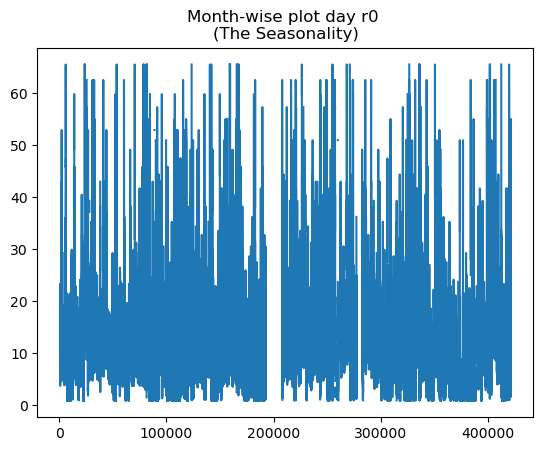

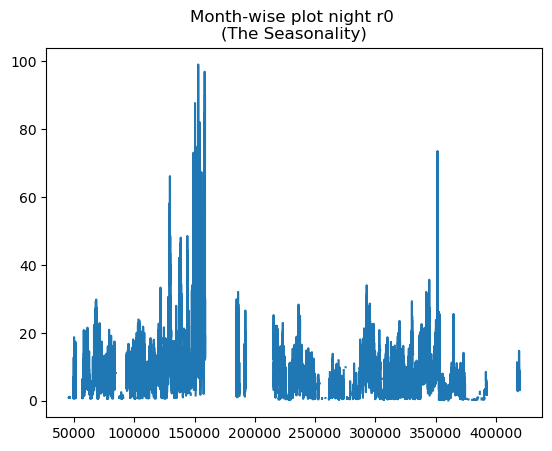

In [70]:
plt.plot('day_r0', data=df.loc[~df.month.isin([7]), :],)
plt.title('Month-wise plot day r0 \n(The Seasonality)', fontsize=12)
plt.show()
plt.plot('night_r0', data=df.loc[~df.month.isin([7]), :],)
plt.title('Month-wise plot night r0 \n(The Seasonality)', fontsize=12)
plt.show()

# Mise en oeuvre algorithme de prédiction des valeurs manquantes

In [7]:
list_cols = list(df.columns)
list_index = list(df.index)

In [8]:
dfComplet = complete_dataset(df,5)
dfMissing = missing_dataset(df,5)

/Users/macbook/Documents/Mines_Nancy/Césure/datacraft/Atelier Miratlas/2310-Yewan-Miratlas/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[var][index] = (var_0 + var_1)/2
/Users/macbook/Documents/Mines_Nancy/Césure/datacraft/Atelier Miratlas/2310-Yewan-Miratlas/utils.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[var][index] = var_0


In [9]:
missingDF(dfComplet)

,0
time,0
d_ext_temp,0
d_humid,0
d_wind_dir,0
down_ir,0
humid,0
irrad,0
press,0
pyr_temp,0
sky_temp,0


On a un dataset complet qui nous servira pour entrainer notre modèle

In [10]:
split = int(0.80*len(dfComplet))
split 

337691